### Preparation

In [3]:
# import basic libraries
import pandas as pd
import numpy as np
import seaborn as sns
import numpy as np

import matplotlib.pyplot as plt

# libraries for models
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

from keras.models import Sequential
from keras.layers import Dense

# additional tools
from tqdm import tqdm

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
df = pd.read_csv('/content/drive/My Drive/games.csv')

In [6]:
df.sample(2)

,Unnamed: 0,Title,Release Date,Team,Rating,Times Listed,Number of Reviews,Genres,Summary,Reviews,Plays,Playing,Backlogs,Wishlist
586,586,Rollerdrome,"Aug 16, 2022","['Roll7', 'Private Division']",3.7,260,260,"['Adventure', 'Indie', 'Shooter', 'Sport']",Rollerdrome is a third person action shooter t...,"['cool ass game', 'A solid hybrid of Max Payne...",431,57,351,492
1282,1282,Super Mario Sunshine,"Sep 18, 2020","['Nintendo EAD', 'Nintendo']",3.7,19,19,"['Adventure', 'Platform']",A port of Super Mario Sunshine included in Sup...,['What an amazing remaster of an already amazi...,340,6,83,14


In [7]:
df.info()

# seems like we have a lot of improper types
# let's fix them throughout preparation

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1512 entries, 0 to 1511
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         1512 non-null   int64  
 1   Title              1512 non-null   object 
 2   Release Date       1512 non-null   object 
 3   Team               1511 non-null   object 
 4   Rating             1499 non-null   float64
 5   Times Listed       1512 non-null   object 
 6   Number of Reviews  1512 non-null   object 
 7   Genres             1512 non-null   object 
 8   Summary            1511 non-null   object 
 9   Reviews            1512 non-null   object 
 10  Plays              1512 non-null   object 
 11  Playing            1512 non-null   object 
 12  Backlogs           1512 non-null   object 
 13  Wishlist           1512 non-null   object 
dtypes: float64(1), int64(1), object(12)
memory usage: 165.5+ KB


In [8]:
# looking through nulls
null_count = df.isnull().sum()
null_count

Unnamed: 0            0
Title                 0
Release Date          0
Team                  1
Rating               13
Times Listed          0
Number of Reviews     0
Genres                0
Summary               1
Reviews               0
Plays                 0
Playing               0
Backlogs              0
Wishlist              0
dtype: int64

In [9]:
null_count[null_count != 0]

Team        1
Rating     13
Summary     1
dtype: int64

### Data pre-processing

In [10]:
df['Release Date'] = pd.to_datetime(df['Release Date'])

# we have an error while converting the date to date type
# we can try to get rid of the releases on TBD

ParserError: ignored

In [11]:
cond = df["Release Date"] == "releases on TBD"
df[cond]

,Unnamed: 0,Title,Release Date,Team,Rating,Times Listed,Number of Reviews,Genres,Summary,Reviews,Plays,Playing,Backlogs,Wishlist
644,644,Deltarune,releases on TBD,['tobyfox'],4.3,313,313,"['Adventure', 'Indie', 'Music', 'Puzzle', 'RPG']","UNDERTALE's parallel story, DELTARUNE. Meet ne...","['Spamton is so hot, I want to kiss him in the...",1.3K,83,468,617
649,649,Death Stranding 2,releases on TBD,['Kojima Productions'],NaN,105,105,"['Adventure', 'Shooter']",NaN,[],3,0,209,644
1252,1252,Elden Ring: Shadow of the Erdtree,releases on TBD,"['FromSoftware', 'Bandai Namco Entertainment']",4.8,18,18,"['Adventure', 'RPG']",An expansion to Elden Ring setting players on ...,['I really loved that they integrated Family G...,1,0,39,146


In [12]:
# let's just drop them, as there are only three variables
df = df.drop([644, 649, 1252], axis=0)

In [13]:
# we can additionally drop other columns, because here we don't need them
df = df.drop(columns=['Unnamed: 0', 'Times Listed', 'Summary', 'Reviews', 'Team'])

In [14]:
# make all the column names lowercase
df.columns = df.columns.str.lower()

# replace spaces with _
df.columns = df.columns.str.replace(' ', '_')

In [15]:
rename_mapper = {"plays":"no_of_plays", "playing":"active_players"}
df.rename(columns=rename_mapper, inplace=True)
df.head(2)

,title,release_date,rating,number_of_reviews,genres,no_of_plays,active_players,backlogs,wishlist
0,Elden Ring,"Feb 25, 2022",4.5,3.9K,"['Adventure', 'RPG']",17K,3.8K,4.6K,4.8K
1,Hades,"Dec 10, 2019",4.3,2.9K,"['Adventure', 'Brawler', 'Indie', 'RPG']",21K,3.2K,6.3K,3.6K


In [16]:
def convert_str_num_to_int(df: pd.DataFrame, col_names: list) -> pd.DataFrame:
   # taking a copy of the provided dataframe
    new_df = df.copy()

    # looping over the column names list
    for col in col_names:
        # replace 'K' with '000'
        new_df[col] = new_df[col].str.replace("K", "000")

        # multiply the values by 1000 to handle decimal values correctly
        new_df[col] = new_df[col].map(lambda x: int(float(x) * 1000) if '.' in x else int(x))

    return new_df

In [17]:
# converting the columns to numeric types
numerical_cols = ["no_of_plays", "active_players", "wishlist", 'number_of_reviews', 'backlogs']
df = convert_str_num_to_int(df, numerical_cols)
df.head(2)

,title,release_date,rating,number_of_reviews,genres,no_of_plays,active_players,backlogs,wishlist
0,Elden Ring,"Feb 25, 2022",4.5,3900,"['Adventure', 'RPG']",17000,3800,4600,4800
1,Hades,"Dec 10, 2019",4.3,2900,"['Adventure', 'Brawler', 'Indie', 'RPG']",21000,3200,6300,3600


In [18]:
# checking the types
df.dtypes

title                 object
release_date          object
rating               float64
number_of_reviews      int64
genres                object
no_of_plays            int64
active_players         int64
backlogs               int64
wishlist               int64
dtype: object

In [19]:
# dropping nulls
df.dropna(inplace=True)

In [20]:
df.head(2)

,title,release_date,rating,number_of_reviews,genres,no_of_plays,active_players,backlogs,wishlist
0,Elden Ring,"Feb 25, 2022",4.5,3900,"['Adventure', 'RPG']",17000,3800,4600,4800
1,Hades,"Dec 10, 2019",4.3,2900,"['Adventure', 'Brawler', 'Indie', 'RPG']",21000,3200,6300,3600


<ipython-input-21-544db7a605b1>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr()


<Axes: >

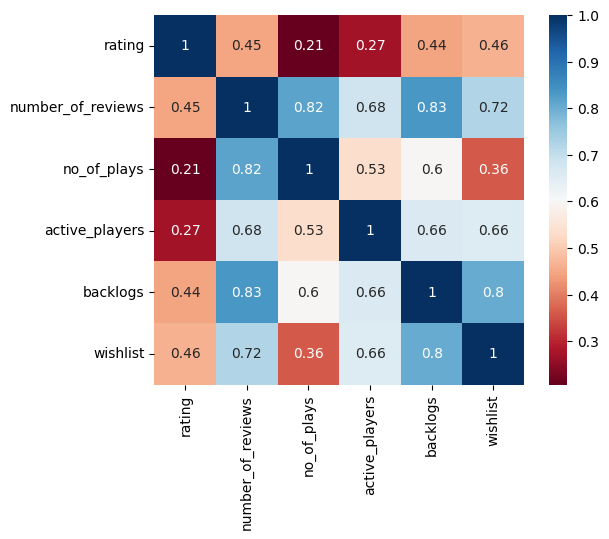

In [21]:
# calculate correlation between columns
corr = df.corr()

# generate a heatmap visualization of the correlation matrix
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, cmap='RdBu', annot=True, square=True)

Here, it seems we have somewhat strong correlation b/w backlogs and wishlist, number of reviews and wishlist, number of reviews and backlogs.

In [ ]:
# we can save dataframe for visualization with dashboards
df.to_csv('/content/drive/My Drive/popular_games.csv')

In [22]:
# replacing '[', ']', and "'" characters in the genres column with nothing
df["genres"] = df["genres"].str.replace('[\[\]\'\"]', "")

# creating a binary matrix of genre values for each game
genres = df["genres"].str.get_dummies(",")

# summing the occurrences of each genre across all games
popularity = genres.sum().sort_values(ascending=False)

# printing the popularity of each genre
popularity.head()

<ipython-input-22-5af118b67b60>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df["genres"] = df["genres"].str.replace('[\[\]\'\"]', "")


Adventure    1005
 RPG          422
 Platform     282
 Shooter      270
 Indie        229
dtype: int64

In [23]:
# converting the popularity to a dataframe
popularity_df = popularity.to_frame(name="popularity")

# merging the popularity data with the game data
df_pop = df.merge(popularity_df, left_on="genres", right_index=True)

# grouping the data by genre
grouped = df_pop.groupby("genres")

In [24]:
df_pop.head(5)

,title,release_date,rating,number_of_reviews,genres,no_of_plays,active_players,backlogs,wishlist,popularity
45,Doom,"May 12, 2016",4.0,1800,Shooter,18000,541,4000,1400,81
53,Doom Eternal,"Mar 19, 2020",4.2,1900,Shooter,12000,738,4600,2400,81
57,Overwatch 2,"Oct 04, 2022",2.7,491,Shooter,6600,1100,292,171,81
58,Resident Evil 4,"Jan 11, 2005",4.3,2300,Shooter,14000,360,3000,1200,81
83,Half-Life 2,"Nov 16, 2004",4.2,1700,Shooter,15000,257,3500,1000,81


In [25]:
# creating a csv file for genres for visualization
df_pop.to_csv('/content/drive/My Drive/genre_popularity.csv')

In [26]:
# which game is the most popular for each genre
def get_most_pop_game(group: pd.DataFrame) -> pd.Series:

   # getting the row with the highest popularity value
    most_popular_game = group.loc[group["popularity"].idxmax()]

    # returning the title of the most popular game
    return most_popular_game["title"]

# applying the function to the grouped dataframe and saving the result (series) into a variable
most_popular_game = grouped.apply(get_most_pop_game)

In [27]:
# converting the series into a dataframe, reseting the index and rename the columns
# to present the most popular game in each video game genre.
most_popular_game.to_frame().reset_index() \
                 .rename({"genres":"Game Genre", 0:"Most Popular Game"}, axis=1)

,Game Genre,Most Popular Game
0,Adventure,Metal Gear Solid 2: Sons of Liberty
1,Arcade,Chrome Dino
2,Brawler,Devil May Cry
3,Card & Board Game,Mario Party Superstars
4,Fighting,MultiVersus
5,Indie,Friday the 13th: The Game
6,MOBA,Pokémon Unite
7,Music,Friday Night Funkin'
8,Platform,Super Mario Bros. 3
9,Puzzle,Tetris


### Models

In [28]:
# let's first take all the features we have
features = ['number_of_reviews', 'no_of_plays', 'active_players', 'backlogs', 'wishlist', 'popularity']
x = df_pop.loc[:, features]
y = df_pop.loc[:, ['rating']]

In [29]:
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=0, train_size=0.75)

#### Random Forest

In [ ]:
# define the parameter grid for random search
param_grid = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2'],
    'bootstrap': [True, False]
}

# create the RandomForestRegressor model
model = RandomForestRegressor(random_state=0)

# perform random search with error_score='raise'
random_search = RandomizedSearchCV(estimator=model, param_distributions=param_grid,
                                   scoring='neg_mean_squared_error', cv=5,
                                   random_state=0, n_iter=10, error_score='raise')

# fit the random search to the training data
random_search.fit(x_train, y_train)

# get the best model from the random search
best_model = random_search.best_estimator_

# make predictions on the test data
y_pred = best_model.predict(x_test)

# evaluate the model using mean squared error
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error: ", mse)
r2 = r2_score(y_test, y_pred)
print("R2 Score: ", r2)

**Random Forest with Random Search**

Mean Squared Error:  0.18988211575937827

R2 Score:  0.3204534030420525

#### XGBoost

In [ ]:
# define the parameter grid for random search
param_grid = {
    'n_estimators': randint(100, 1000),
    'max_depth': randint(1, 10),
    'learning_rate': uniform(0.01, 0.5),
    'subsample': uniform(0.5, 0.5),
    'colsample_bytree': uniform(0.5, 0.5),
    'gamma': uniform(0, 0.5)
}

# create the XGBoost regressor
model = XGBRegressor(objective='reg:squarederror')

# perform random search
random_search = RandomizedSearchCV(estimator=model, param_distributions=param_grid,
                                   scoring='neg_mean_squared_error', cv=5,
                                   random_state=0, n_iter=10, error_score='raise')

# fit the random search to the training data
random_search.fit(x_train, y_train)

# get the best model from random search
best_model = random_search.best_estimator_

# make predictions on the test data
y_pred = best_model.predict(x_test)

# evaluate the model using R2 score, MAE, and RMSE
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
print("R2 Score: ", r2)
print("Mean Absolute Error: ", mae)
print("Root Mean Squared Error: ", rmse)

Predicting:   0%|          | 0/100 [00:00<?, ?it/s]

R2 Score:  0.2948723189187711
Mean Absolute Error:  0.3206812422040482
Root Mean Squared Error:  0.44388073055632177


**XGBoost**

R2 Score:  0.2948723189187711

Mean Absolute Error:  0.3206812422040482

Root Mean Squared Error:  0.44388073055632177

## Change the model

As we have low values for our models, we can try to lower the number of features and take only those meaningful for our target variable.

<ipython-input-31-495e99c97719>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df_pop.corr()


<Axes: >

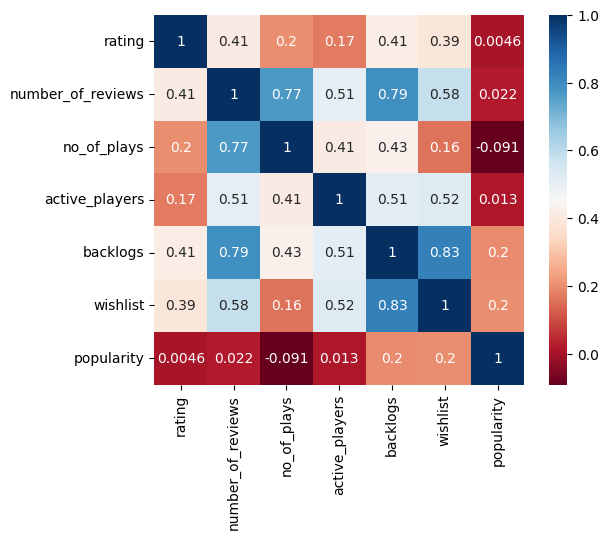

In [31]:
# calculate correlation between columns
corr = df_pop.corr()

# generate a heatmap visualization of the correlation matrix
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, cmap='RdBu', annot=True, square=True)

In [32]:
df_pop.head(2)

,title,release_date,rating,number_of_reviews,genres,no_of_plays,active_players,backlogs,wishlist,popularity
45,Doom,"May 12, 2016",4.0,1800,Shooter,18000,541,4000,1400,81
53,Doom Eternal,"Mar 19, 2020",4.2,1900,Shooter,12000,738,4600,2400,81


In [33]:
df_pop1 = df_pop.drop(columns=['title', 'release_date', 'genres'])
df_pop1.head(1)

,rating,number_of_reviews,no_of_plays,active_players,backlogs,wishlist,popularity
45,4.0,1800,18000,541,4000,1400,81


Rating is our target variable

We can take number_of_reviews, backlogs, and wishlist as meaningful features.


In [34]:
df_pop1 = df_pop1.drop(columns=['active_players', 'no_of_plays', 'popularity'])

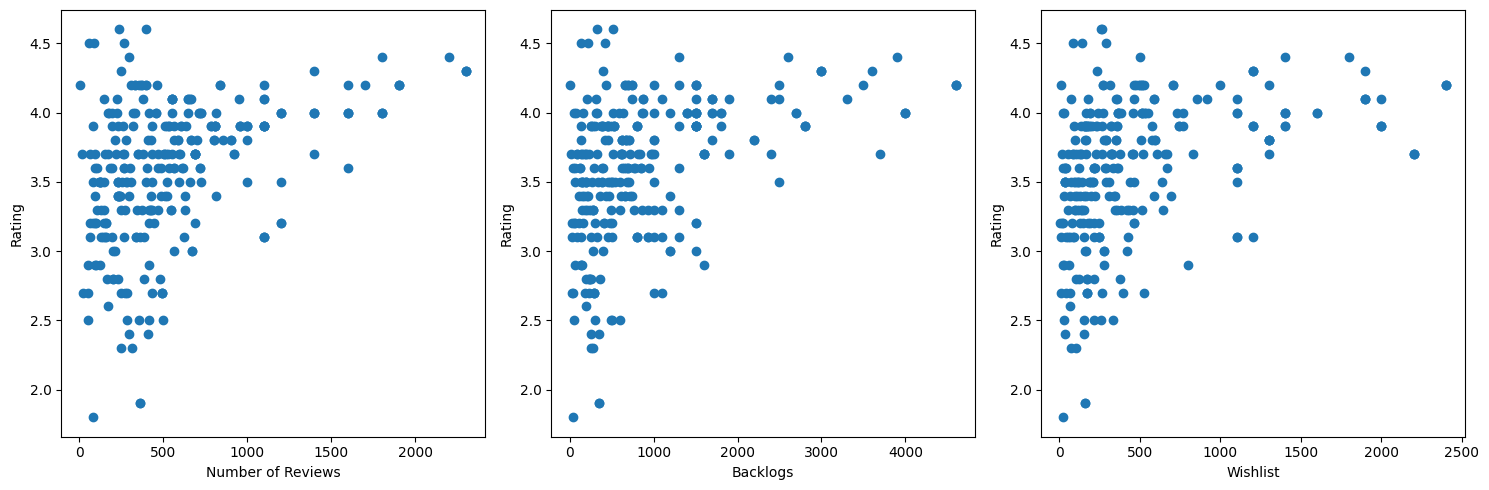

In [35]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].scatter(df_pop1['number_of_reviews'], df_pop1['rating'])
axs[0].set_xlabel('Number of Reviews')
axs[0].set_ylabel('Rating')

axs[1].scatter(df_pop1['backlogs'], df_pop1['rating'])
axs[1].set_xlabel('Backlogs')
axs[1].set_ylabel('Rating')

axs[2].scatter(df_pop1['wishlist'], df_pop1['rating'])
axs[2].set_xlabel('Wishlist')
axs[2].set_ylabel('Rating')

plt.tight_layout()
plt.show()

The features are positively correlated.

In [36]:
features = ['number_of_reviews', 'backlogs', 'wishlist']
x = df_pop1.loc[:, features]
y = df_pop1.loc[:, ['rating']]

In [37]:
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=0, train_size=0.75)

In [ ]:
# define the parameter grid for random search
param_grid = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2'],
    'bootstrap': [True, False]
}

# create the RandomForestRegressor model
model = RandomForestRegressor(random_state=0)

# perform random search with error_score='raise'
random_search = RandomizedSearchCV(estimator=model, param_distributions=param_grid,
                                   scoring='neg_mean_squared_error', cv=5,
                                   random_state=0, n_iter=10, error_score='raise')

# fit the random search to the training data
random_search.fit(x_train, y_train)

# get the best model from the random search
best_model = random_search.best_estimator_

# make predictions on the test data
y_pred = best_model.predict(x_test)

# evaluate the model using mean squared error
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error: ", mse)
r2 = r2_score(y_test, y_pred)
print("R2 Score: ", r2)

**Random Forest**

Mean Squared Error:  0.17040259040261457

R2 Score:  0.3901663673915716

### Logarithmic transformation

As our features of the same scale but of different with the target variable, we can try to take a log of them.

In [47]:
# define the features and target variable
features = ['number_of_reviews', 'backlogs', 'wishlist']
x = df_pop1.loc[:, features]
y = df_pop1.loc[:, 'rating']

# take the logarithm of the selected features
x['number_of_reviews'] = np.log(x['number_of_reviews'])
x['backlogs'] = np.log(x['backlogs'])
x['wishlist'] = np.log(x['wishlist'])

# define the parameter grid for random search
param_grid = {
    'n_estimators': randint(100, 1000),
    'max_depth': randint(1, 10),
    'learning_rate': uniform(0.01, 0.5),
    'subsample': uniform(0.5, 0.5),
    'colsample_bytree': uniform(0.5, 0.5),
    'gamma': uniform(0, 0.5)
}

# create the XGBoost regressor
model = XGBRegressor(objective='reg:squarederror')

# perform random search
random_search = RandomizedSearchCV(estimator=model, param_distributions=param_grid,
                                   scoring='neg_mean_squared_error', cv=5,
                                   random_state=0, n_iter=10, error_score='raise')

# fit the random search to the training data
random_search.fit(x, y)

# get the best model from random search
best_model = random_search.best_estimator_

# make predictions on the test data
y_pred = best_model.predict(x)

# evaluate the model using R2 score, MAE, and RMSE
r2 = r2_score(y, y_pred)
mae = mean_absolute_error(y, y_pred)
rmse = mean_squared_error(y, y_pred, squared=False)
print("R2 Score: ", r2)
print("Mean Absolute Error: ", mae)
print("Root Mean Squared Error: ", rmse)

R2 Score:  0.8297403567088253
Mean Absolute Error:  0.16734585745114805
Root Mean Squared Error:  0.2091436874778894


R2 Score:  0.8297403567088253

Mean Absolute Error:  0.16734585745114805

Root Mean Squared Error:  0.2091436874778894